# Calculate NLP statistics over classification results in excel format
Analyse a excel sheet of NLP classification results.

Use yaml config

In [1]:
use_config_file = True
config_file = './../resources/config/result-analysis-tn-tn-val.yaml'
cfg = None
if use_config_file:
    import yaml
    with open(config_file, 'r') as yaml_file:
        cfg = yaml.safe_load(yaml_file)


Set path of excel sheet

In [2]:
path_excel_sheet = "./../resources/data_ignored/results-tn-train.xlsx"
if use_config_file:
    path_excel_sheet = cfg['path_excel_sheet']


Set output directory

In [3]:
path_output_dir = "./../resources/"

out_file = None
out_file_excel = None
if use_config_file:
    path_output_dir = cfg['path_output_dir']
try:
    from pathlib import Path
    Path(path_output_dir).mkdir(parents=True, exist_ok=True)
    out_file = open(path_output_dir + "/"+ "result-analysis-out.txt", "w")
    out_file_excel = path_output_dir + "/"+ "result-analysis-out.xlsx"
except OSError:
    print ("Creation of the directory %s failed" % path_output_dir)
else:
    print ("Successfully created the directory %s " % path_output_dir)
    

Successfully created the directory ./../resources/results/results-tn-val-merge-result 


Set label and classification columns

In [4]:
column_actual = 'label longembolie'
column_predicted = 'target-snomedct:59282003'

if use_config_file:
    column_actual = cfg['column_actual']
    column_predicted = cfg['column_predicted']

Read columns and determine values, in case of key error, make sure the columns are set correctly

In [5]:
import pandas
df = pandas.read_excel(path_excel_sheet, header=0)

actual_values = df[column_actual].value_counts().index.tolist() 
predicted_values = df[column_predicted].value_counts().index.tolist() 

print('actual category values:', actual_values)
print('predicted category values:', predicted_values)
all_values = list(set(actual_values).union(set(predicted_values)))
print(all_values)

actual category values: ['??', 'T4N2', 'T1cN0', 'T3N2', 'T4N0', 'T2bN2', 'T4N3', 'T3N3', 'T3N0', 'T1cN2', 'T2aN0', 'T2aN2', 'T2N2', 'T1cN1', 'T4N1', 'T2bN3', 'T1bN0', 'T2bN0', 'T2bN1', 'T2aN1', 'T1bN3', 'T1bN2', 'T2N0', 'T2N3', 'T1cN3', 'T2aN3']
predicted category values: ['T4N2', 'T1cN0', 'T3N2', 'T2bN2', 'T4N0', 'T4N3', 'T3N0', 'T2aN0', 'T1cN2', 'T3N3', 'T4N1', 'T2aN3', 'T2aN2', 'T1cN3', 'T0N3', 'T2N2', 'T1bN0', 'T2bN3', 'T2aN1', 'T1cN1', 'T0N0', 'T1bN3', 'T1bN2', 'T2N3', 'T2bN1', 'T0N2', 'T3N1', 'T2N0', 'T2bN0']
['T3N2', '??', 'T2aN0', 'T2bN3', 'T1bN2', 'T2aN1', 'T1cN1', 'T2aN2', 'T3N0', 'T4N0', 'T2N3', 'T4N2', 'T2N2', 'T1cN2', 'T0N0', 'T3N1', 'T1bN0', 'T2bN2', 'T2bN1', 'T4N1', 'T1bN3', 'T0N2', 'T2bN0', 'T3N3', 'T1cN3', 'T1cN0', 'T4N3', 'T0N3', 'T2N0', 'T2aN3']


Manually set valid values from actual and predicted categories (other values will be ignored)

In [6]:
valid_values = []
ignored_values = []

if use_config_file and 'valid_values' in cfg:
    valid_values = cfg['valid_values']
if use_config_file and 'ignored_values' in cfg:
    ignored_values = cfg['ignored_values']

if not valid_values or len(valid_values) == 0:
    valid_values = all_values
    
def matches_ignored(x):
    for ignored in ignored_values:
        if ignored in x:
            return True
    return False
    
valid_values = [] 
for x in all_values:
    if not matches_ignored(x):
        valid_values.append(x)

valid_values.sort()

Check valid values

In [7]:
df_valid = df[df[column_actual].isin(valid_values)]

actual_index_valid = df_valid[column_actual].value_counts().index.tolist() 
predicted_index_valid = df_valid[column_predicted].value_counts().index.tolist() 

print('actual category values:', actual_index_valid)
print('predicted category values:', predicted_index_valid)

actual category values: ['T4N2', 'T1cN0', 'T3N2', 'T4N0', 'T3N3', 'T2bN2', 'T3N0', 'T4N3', 'T1cN2', 'T2aN0', 'T2aN2', 'T1cN1', 'T2N2', 'T2bN1', 'T2bN3', 'T2bN0', 'T4N1', 'T1bN0', 'T1cN3', 'T2N0', 'T1bN2', 'T2aN3', 'T1bN3', 'T2N3', 'T2aN1']
predicted category values: ['T4N2', 'T1cN0', 'T3N2', 'T2bN2', 'T4N3', 'T4N0', 'T3N0', 'T1cN2', 'T3N3', 'T2aN0', 'T2aN2', 'T2aN1', 'T4N1', 'T1cN1', 'T1bN0', 'T2N2', 'T2bN3', 'T2aN3', 'T2bN1', 'T1bN2', 'T2N0', 'T2N3', 'T1bN3', 'T0N0', 'T2bN0']


Histograms Original

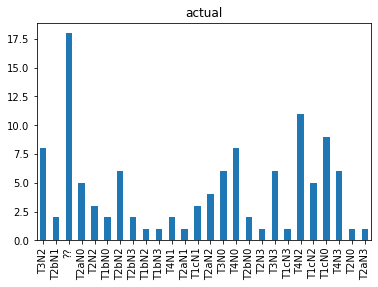

In [8]:
actual_bar_plt = df[column_actual].value_counts(sort = False).plot(kind='bar', title='actual')

Histograms Valid Values only

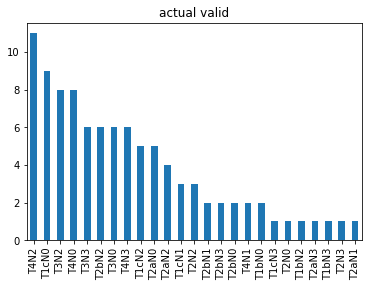

In [9]:
actual_valid_bar_plot = df_valid[column_actual].value_counts().plot(kind='bar', title='actual valid')

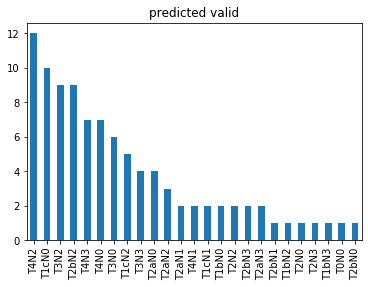

In [10]:
predicted_valid_bar_plt = df_valid[column_predicted].value_counts().plot(kind='bar', title='predicted valid')

Metrics

In [11]:
df = df_valid

from sklearn.metrics import precision_recall_fscore_support, confusion_matrix
y_actu = pandas.Series(df[column_actual], name='Actual')
y_pred = pandas.Series(df[column_predicted], name='Predicted')

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

accuracy = "accuracy = " + str(round(accuracy_score(y_actu, y_pred), 4))
print(accuracy)
out_file.write(accuracy + "\n\n")

avg = ["micro", "macro", "weighted"]
for avg_opt in avg:
    a_precision = avg_opt + "_precision = " + str(round(precision_score(y_actu, y_pred, average=avg_opt), 4))
    a_recall_score = avg_opt + "_recall_score = " + str(round(recall_score(y_actu, y_pred, average=avg_opt), 4))
    a_f1 = avg_opt + "_f1 = " + str(round(f1_score(y_actu, y_pred, average=avg_opt), 4))
    print(a_precision)
    print(a_recall_score)
    print(a_f1)       
    out_file.write(a_precision + "\n")
    out_file.write(a_recall_score + "\n")
    out_file.write(a_f1 + "\n")
    out_file.write("\n")

prf = precision_recall_fscore_support(y_actu, y_pred, average=None, labels=valid_values)
evaldf = pandas.DataFrame({"Precision": prf[0], "Recall": prf[1], "F-score": prf[2]}, index=valid_values)
print(evaldf)
out_file.write(str(evaldf) + "\n\n")

accuracy = 0.8247
micro_precision = 0.8247
micro_recall_score = 0.8247
micro_f1 = 0.8247
macro_precision = 0.7946
macro_recall_score = 0.7664
macro_f1 = 0.7611
weighted_precision = 0.8473
weighted_recall_score = 0.8247
weighted_f1 = 0.8223
       Precision    Recall   F-score
T0N0    0.000000  0.000000  0.000000
T0N2    0.000000  0.000000  0.000000
T0N3    0.000000  0.000000  0.000000
T1bN0   1.000000  1.000000  1.000000
T1bN2   1.000000  1.000000  1.000000
T1bN3   1.000000  1.000000  1.000000
T1cN0   0.900000  1.000000  0.947368
T1cN1   1.000000  0.666667  0.800000
T1cN2   0.800000  0.800000  0.800000
T1cN3   0.000000  0.000000  0.000000
T2N0    1.000000  1.000000  1.000000
T2N2    1.000000  0.666667  0.800000
T2N3    1.000000  1.000000  1.000000
T2aN0   1.000000  0.800000  0.888889
T2aN1   0.500000  1.000000  0.666667
T2aN2   0.666667  0.500000  0.571429
T2aN3   0.500000  1.000000  0.666667
T2bN0   1.000000  0.500000  0.666667
T2bN1   1.000000  0.500000  0.666667
T2bN2   0.666667  1.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarnin

1111

Create confusion matrix

In [12]:
crosstab = pandas.crosstab(y_actu, y_pred, rownames=['Actual'], colnames=['Predicted'], margins=True)
print("CONFUSION MATRIX")
print(crosstab)
out_file.write(str(crosstab))


import openpyxl
crosstab.to_excel(out_file_excel)


CONFUSION MATRIX
Predicted  T0N0  T1bN0  T1bN2  T1bN3  T1cN0  T1cN1  T1cN2  T2N0  T2N2  T2N3  \
Actual                                                                        
T1bN0         0      2      0      0      0      0      0     0     0     0   
T1bN2         0      0      1      0      0      0      0     0     0     0   
T1bN3         0      0      0      1      0      0      0     0     0     0   
T1cN0         0      0      0      0      9      0      0     0     0     0   
T1cN1         0      0      0      0      1      2      0     0     0     0   
T1cN2         0      0      0      0      0      0      4     0     0     0   
T1cN3         0      0      0      0      0      0      1     0     0     0   
T2N0          0      0      0      0      0      0      0     1     0     0   
T2N2          0      0      0      0      0      0      0     0     2     0   
T2N3          0      0      0      0      0      0      0     0     0     1   
T2aN0         1      0      0      

Plot confusion matrix

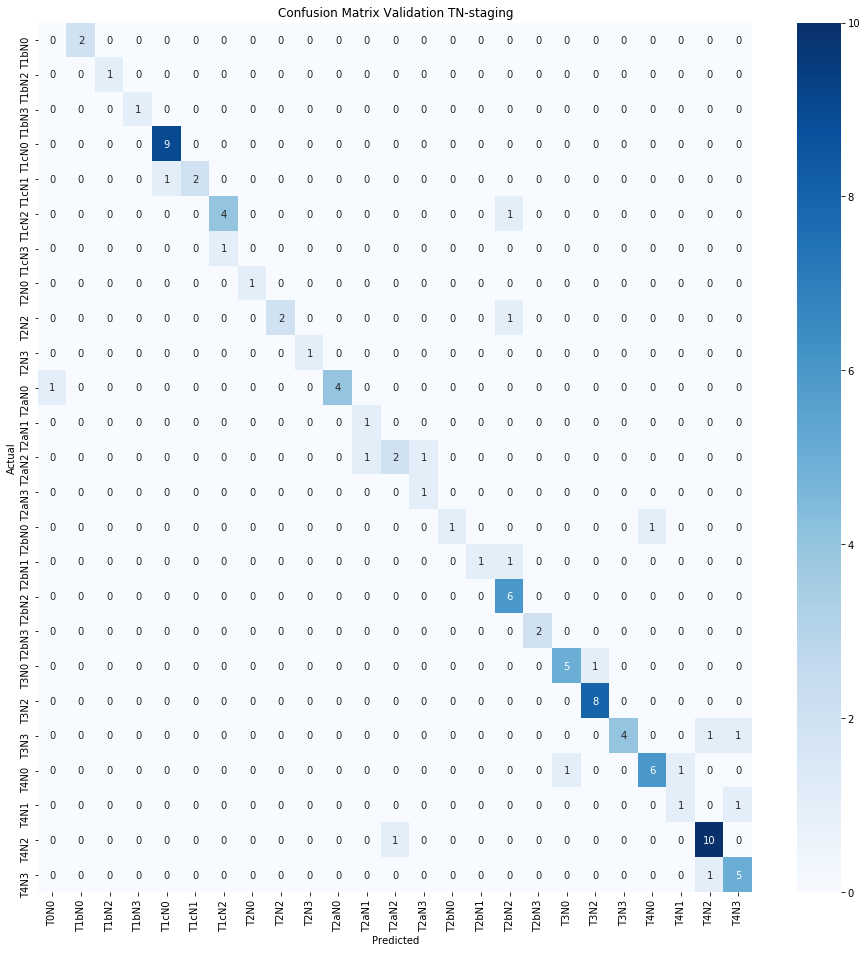

In [13]:
import seaborn
import matplotlib
import matplotlib.pyplot as plt

data = {'y_Actual': df_valid[column_actual], 'y_Predicted': df_valid[column_predicted]}
df = pandas.DataFrame(data, columns=['y_Actual','y_Predicted'])

confusion_matrix = pandas.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

plt.figure(figsize=(16,16))  
plt.title(cfg['title_confusion_matrix'])

confusion_matrix_heatmap = seaborn.heatmap(confusion_matrix, annot=True, cmap=matplotlib.cm.Blues)



Save confusion matix figure to file

In [14]:
file_type_eps = False
fig = confusion_matrix_heatmap.get_figure()
if file_type_eps:
    fig.savefig(path_output_dir + "/" + "confusion_matrix.eps", dict="eps", dpi=600)
else:
   fig.savefig(path_output_dir + "/" + "confusion_matrix.png", dpi=600)

out_file.close()